# Analise de configuração da rede MLP com a base Mammography

Leitura da base de dados

In [1]:
import pandas as pd

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler

from scripts.extensions import *
from IPython.display import display
from scripts.plot_util import *
from scripts.train_util import *

NOTEBOOK = True

print('read database')
db_file = 'database.csv'
db_frame = pd.read_csv(db_file, header=None)
print(f'instances: {db_frame.shape[0]}')
print()

read database
instances: 11183



Separação de instâncias positivas e negativas

In [2]:
print('split negatives and positives')
negs_frame = db_frame[db_frame.iloc[:, -1] == 0]
poss_frame = db_frame[db_frame.iloc[:, -1] == 1]
print('shuffle negatives and positives')
negs_frame = negs_frame.sample(frac=1).reset_index(drop=True)
poss_frame = poss_frame.sample(frac=1).reset_index(drop=True)
print(f'neg: {negs_frame.shape[0]}, pos: {poss_frame.shape[0]}')
print()

split negatives and positives
shuffle negatives and positives
neg: 10923, pos: 260



Divisão das instâncias usando k-fold cross validation com 10 folds

In [3]:
k = 10
print(f'create k={k} folds')
negs_frame_folds = np.array_split(negs_frame, k)
poss_frame_folds = np.array_split(poss_frame, k)
print('merge and shuffle individual folds')
frame_folds = [pd.concat([negs_frame_folds[i], poss_frame_folds[i]], axis=0, join='outer') for i in range(k)]
frame_folds = [ff.sample(frac=1).reset_index(drop=True) for ff in frame_folds]
print(f'split instances and classes and transform in numpy arrays')
base_folds = [(ff.iloc[:, :-1].values, ff.iloc[:, -1].values) for ff in frame_folds]
print('\n'.join(f'{i}: n={negs_frame_folds[i].shape[0]} p={poss_frame_folds[i].shape[0]} t={frame_folds[i].shape[0]}'
                for i in range(k)))
print()

create k=10 folds
merge and shuffle individual folds
split instances and classes and transform in numpy arrays
0: n=1093 p=26 t=1119
1: n=1093 p=26 t=1119
2: n=1093 p=26 t=1119
3: n=1092 p=26 t=1118
4: n=1092 p=26 t=1118
5: n=1092 p=26 t=1118
6: n=1092 p=26 t=1118
7: n=1092 p=26 t=1118
8: n=1092 p=26 t=1118
9: n=1092 p=26 t=1118



Resample da amostra usando algoritmos de under sampling e over sampling, os algoritmos usados foram
RandomOverSampler, SMOTE, ClusterCentroids (K-Means) e RandomUnderSampler

Os algoritmos são aplicados individualmente em cada fold para que não haja sobreposição dos dados em diferentes folds

In [4]:
print('resample folds')
samplers = {
    'r-over': RandomOverSampler(), 'smote': SMOTE(),
    'k-means': ClusterCentroids(), 'r-under': RandomUnderSampler()
}
samples_folds = {name: [sampler.fit_sample(*fold) for fold in base_folds] for name, sampler in samplers.items()}
for name, sample_folds in samples_folds.items():
    print('sampler %s folds: %s' % (name, [len(fold[0]) for fold in sample_folds]))
print()

resample folds
sampler r-over folds: [2186, 2186, 2186, 2184, 2184, 2184, 2184, 2184, 2184, 2184]
sampler smote folds: [2186, 2186, 2186, 2184, 2184, 2184, 2184, 2184, 2184, 2184]
sampler k-means folds: [52, 52, 52, 52, 52, 52, 52, 52, 52, 52]
sampler r-under folds: [52, 52, 52, 52, 52, 52, 52, 52, 52, 52]



Configurações base, a partir destas, cada atributo será testado independentemente

In [5]:
model_class = ModMLPClassifier

base_configurations = [
    {
        'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,),
        'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'max_iter': 200,

        'train_folds': k - 1,  # number of training folds (the last will be choose to validate)
        'max_fail': 3  # max number of consecutive fails in validation score reduction
    },
    {
        'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,),
        'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'max_iter': 800,

        'train_folds': k - 1,  # number of training folds (the last will be choose to validate)
        'max_fail': 3  # max number of consecutive fails in validation score reduction
    },
    {
        'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,),
        'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'max_iter': 3200,

        'train_folds': k - 1,  # number of training folds (the last will be choose to validate)
        'max_fail': 3  # max number of consecutive fails in validation score reduction
    }
]
print('base configurations:')
if NOTEBOOK:
    display(pd.DataFrame(base_configurations))
else:
    print(pd.DataFrame(base_configurations).to_string())

base configurations:


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail
0,sgd,logistic,True,"(8,)",0.0100,invscaling,200,9,3
1,sgd,logistic,True,"(16,)",0.0010,adaptive,800,9,3
2,sgd,logistic,True,"(32,)",0.0001,constant,3200,9,3


Atributos principais a seram variados e seus valores

In [6]:
variations = [
    ('learning_rate_init', [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]),
    ('hidden_layer_sizes', [(2 ** x,) for x in range(1, 8)]),
    ('max_iter', [200, 400, 800, 1600, 3200, 6400]),
    ('learning_rate', ['constant', 'invscaling', 'adaptive']),
    ('activation', ['relu', 'logistic', 'tanh'])
]

if NOTEBOOK:
    display(pd.DataFrame(variations))
else:
    print(pd.DataFrame(variations).to_string())

,0,1
0,learning_rate_init,"[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]"
1,hidden_layer_sizes,"[(2,), (4,), (8,), (16,), (32,), (64,), (128,)]"
2,max_iter,"[200, 400, 800, 1600, 3200, 6400]"
3,learning_rate,"[constant, invscaling, adaptive]"
4,activation,"[relu, logistic, tanh]"


Testes individuais com as diferentes bases geradas com os algoritmos de sampling
* K-Means

optimize model configuration for r-over with configuration range of 3
variation 0 -> learning_rate_init
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
11,sgd,logistic,True,"(16,)",0.0500,adaptive,800,9,3,0.902442,0.097558,0.931660
17,sgd,logistic,True,"(32,)",0.0500,constant,3200,9,3,0.904853,0.095147,0.928736
10,sgd,logistic,True,"(16,)",0.0100,adaptive,800,9,3,0.874542,0.125458,0.921702
5,sgd,logistic,True,"(8,)",0.0500,invscaling,200,9,3,0.871054,0.128946,0.920595
16,sgd,logistic,True,"(32,)",0.0100,constant,3200,9,3,0.889652,0.110348,0.920178
14,sgd,logistic,True,"(32,)",0.0010,constant,3200,9,3,0.869353,0.130647,0.916457
4,sgd,logistic,True,"(8,)",0.0100,invscaling,200,9,3,0.794162,0.205838,0.915464
9,sgd,logistic,True,"(16,)",0.0050,adaptive,800,9,3,0.874628,0.125372,0.913918
8,sgd,logistic,True,"(16,)",0.0010,adaptive,800,9,3,0.864167,0.135833,0.909006
15,sgd,logistic,True,"(32,)",0.0050,constant,3200,9,3,0.881876,0.118124,0.908574


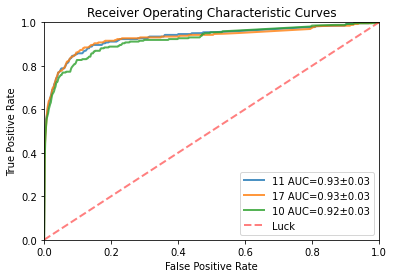


variation 1 -> hidden_layer_sizes
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
2,sgd,logistic,True,"(8,)",0.05,adaptive,800,9,3,0.900381,0.099619,0.937220
8,sgd,logistic,True,"(4,)",0.05,constant,3200,9,3,0.899492,0.100508,0.935281
7,sgd,logistic,True,"(2,)",0.05,constant,3200,9,3,0.912007,0.087993,0.934802
1,sgd,logistic,True,"(4,)",0.05,adaptive,800,9,3,0.900381,0.099619,0.934397
3,sgd,logistic,True,"(16,)",0.05,adaptive,800,9,3,0.900116,0.099884,0.931931
0,sgd,logistic,True,"(2,)",0.05,adaptive,800,9,3,0.908968,0.091032,0.931011
9,sgd,logistic,True,"(8,)",0.05,constant,3200,9,3,0.902889,0.097111,0.930447
16,sgd,logistic,True,"(8,)",0.01,adaptive,800,9,3,0.878562,0.121438,0.929569
4,sgd,logistic,True,"(32,)",0.05,adaptive,800,9,3,0.899131,0.100869,0.927934
15,sgd,logistic,True,"(4,)",0.01,adaptive,800,9,3,0.883749,0.116251,0.927406


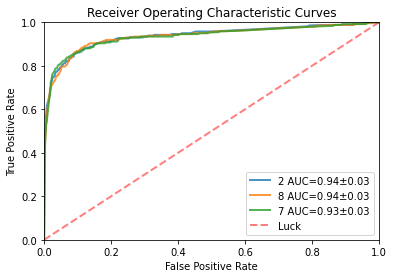


variation 2 -> max_iter
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
12,sgd,logistic,True,"(2,)",0.05,constant,200,9,3,0.906458,0.093542,0.941676
3,sgd,logistic,True,"(8,)",0.05,adaptive,1600,9,3,0.908515,0.091485,0.941485
9,sgd,logistic,True,"(4,)",0.05,constant,1600,9,3,0.913078,0.086922,0.939893
10,sgd,logistic,True,"(4,)",0.05,constant,3200,9,3,0.911470,0.088530,0.939565
13,sgd,logistic,True,"(2,)",0.05,constant,400,9,3,0.917909,0.082091,0.938761
7,sgd,logistic,True,"(4,)",0.05,constant,400,9,3,0.912990,0.087010,0.937581
2,sgd,logistic,True,"(8,)",0.05,adaptive,800,9,3,0.911113,0.088887,0.937439
14,sgd,logistic,True,"(2,)",0.05,constant,800,9,3,0.912096,0.087904,0.937231
5,sgd,logistic,True,"(8,)",0.05,adaptive,6400,9,3,0.909680,0.090320,0.936510
16,sgd,logistic,True,"(2,)",0.05,constant,3200,9,3,0.909056,0.090944,0.936128


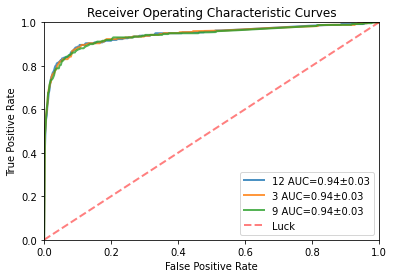


variation 3 -> learning_rate
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 1600, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 1600, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
2,sgd,logistic,True,"(2,)",0.05,adaptive,200,9,3,0.914961,0.085039,0.938229
6,sgd,logistic,True,"(4,)",0.05,constant,1600,9,3,0.907268,0.092732,0.937562
8,sgd,logistic,True,"(4,)",0.05,adaptive,1600,9,3,0.912011,0.087989,0.935657
0,sgd,logistic,True,"(2,)",0.05,constant,200,9,3,0.917645,0.082355,0.935375
3,sgd,logistic,True,"(8,)",0.05,constant,1600,9,3,0.901816,0.098184,0.934828
5,sgd,logistic,True,"(8,)",0.05,adaptive,1600,9,3,0.898418,0.101582,0.934811
1,sgd,logistic,True,"(2,)",0.05,invscaling,200,9,3,0.853525,0.146475,0.919123
7,sgd,logistic,True,"(4,)",0.05,invscaling,1600,9,3,0.863900,0.136100,0.917286
4,sgd,logistic,True,"(8,)",0.05,invscaling,1600,9,3,0.874453,0.125547,0.916993


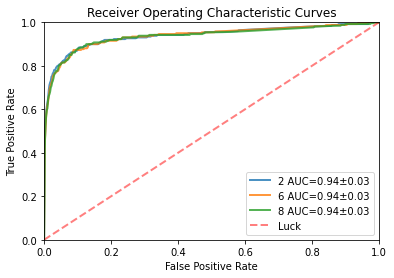


variation 4 -> activation
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 1600, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 1600, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
6,sgd,relu,True,"(4,)",0.05,adaptive,1600,9,3,0.934002,0.065998,0.945000
3,sgd,relu,True,"(4,)",0.05,constant,1600,9,3,0.927031,0.072969,0.943081
1,sgd,logistic,True,"(2,)",0.05,adaptive,200,9,3,0.920502,0.079498,0.941983
4,sgd,logistic,True,"(4,)",0.05,constant,1600,9,3,0.909322,0.090678,0.939350
7,sgd,logistic,True,"(4,)",0.05,adaptive,1600,9,3,0.905299,0.094701,0.939242
0,sgd,relu,True,"(2,)",0.05,adaptive,200,9,3,0.931236,0.068764,0.939071
8,sgd,tanh,True,"(4,)",0.05,adaptive,1600,9,3,0.925866,0.074134,0.938665
2,sgd,tanh,True,"(2,)",0.05,adaptive,200,9,3,0.927834,0.072166,0.938365
5,sgd,tanh,True,"(4,)",0.05,constant,1600,9,3,0.921751,0.078249,0.931231


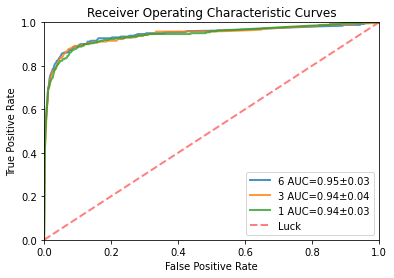


best configuration


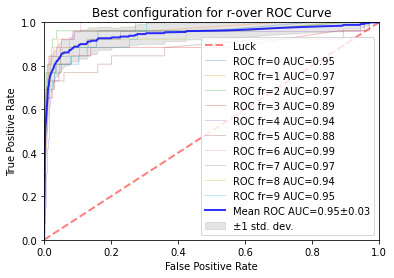

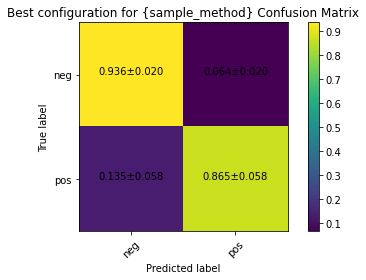

testing overfiting (increased verbose)
run 1 of 1, fold 1 of 10
run 1 of 1, fold 2 of 10
run 1 of 1, fold 3 of 10
run 1 of 1, fold 4 of 10
run 1 of 1, fold 5 of 10
run 1 of 1, fold 6 of 10
run 1 of 1, fold 7 of 10
run 1 of 1, fold 8 of 10
run 1 of 1, fold 9 of 10
run 1 of 1, fold 10 of 10


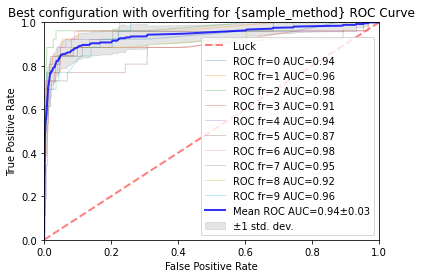

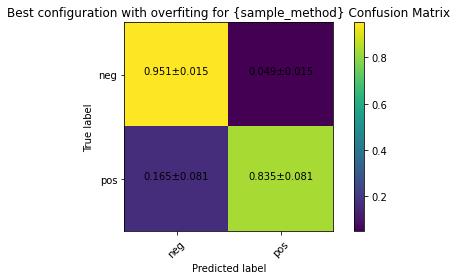




optimize model configuration for smote with configuration range of 3
variation 0 -> learning_rate_init
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
11,sgd,logistic,True,"(16,)",0.0500,adaptive,800,9,3,0.901189,0.098811,0.931561
17,sgd,logistic,True,"(32,)",0.0500,constant,3200,9,3,0.896093,0.103907,0.927322
16,sgd,logistic,True,"(32,)",0.0100,constant,3200,9,3,0.896182,0.103818,0.925858
10,sgd,logistic,True,"(16,)",0.0100,adaptive,800,9,3,0.882138,0.117862,0.922233
15,sgd,logistic,True,"(32,)",0.0050,constant,3200,9,3,0.891258,0.108742,0.918962
5,sgd,logistic,True,"(8,)",0.0500,invscaling,200,9,3,0.874720,0.125280,0.916402
9,sgd,logistic,True,"(16,)",0.0050,adaptive,800,9,3,0.885894,0.114106,0.912564
13,sgd,logistic,True,"(32,)",0.0005,constant,3200,9,3,0.879100,0.120900,0.909208
8,sgd,logistic,True,"(16,)",0.0010,adaptive,800,9,3,0.866319,0.133681,0.907194
7,sgd,logistic,True,"(16,)",0.0005,adaptive,800,9,3,0.867118,0.132882,0.907103


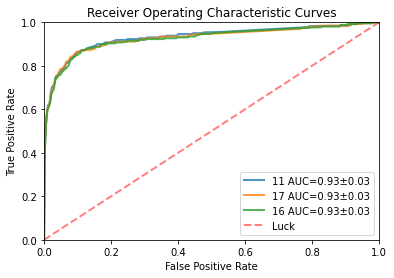


variation 1 -> hidden_layer_sizes
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
2,sgd,logistic,True,"(8,)",0.05,adaptive,800,9,3,0.906644,0.093356,0.938030
0,sgd,logistic,True,"(2,)",0.05,adaptive,800,9,3,0.909684,0.090316,0.937358
8,sgd,logistic,True,"(4,)",0.05,constant,3200,9,3,0.906821,0.093179,0.936718
1,sgd,logistic,True,"(4,)",0.05,adaptive,800,9,3,0.911297,0.088703,0.934992
7,sgd,logistic,True,"(2,)",0.05,constant,3200,9,3,0.901011,0.098989,0.934841
9,sgd,logistic,True,"(8,)",0.05,constant,3200,9,3,0.905572,0.094428,0.934324
10,sgd,logistic,True,"(16,)",0.05,constant,3200,9,3,0.900922,0.099078,0.932253
4,sgd,logistic,True,"(32,)",0.05,adaptive,800,9,3,0.901280,0.098720,0.930594
11,sgd,logistic,True,"(32,)",0.05,constant,3200,9,3,0.898328,0.101672,0.928712
5,sgd,logistic,True,"(64,)",0.05,adaptive,800,9,3,0.903424,0.096576,0.927738


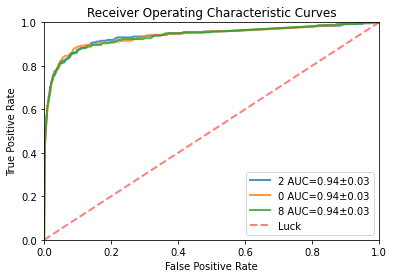


variation 2 -> max_iter
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
17,sgd,logistic,True,"(4,)",0.05,constant,6400,9,3,0.914781,0.085219,0.940822
14,sgd,logistic,True,"(4,)",0.05,constant,800,9,3,0.907450,0.092550,0.939278
6,sgd,logistic,True,"(2,)",0.05,adaptive,200,9,3,0.924261,0.075739,0.938576
3,sgd,logistic,True,"(8,)",0.05,adaptive,1600,9,3,0.905931,0.094069,0.938106
13,sgd,logistic,True,"(4,)",0.05,constant,400,9,3,0.914156,0.085844,0.937858
0,sgd,logistic,True,"(8,)",0.05,adaptive,200,9,3,0.909772,0.090228,0.936953
8,sgd,logistic,True,"(2,)",0.05,adaptive,800,9,3,0.917105,0.082895,0.936526
5,sgd,logistic,True,"(8,)",0.05,adaptive,6400,9,3,0.911921,0.088079,0.936405
9,sgd,logistic,True,"(2,)",0.05,adaptive,1600,9,3,0.908073,0.091927,0.936111
15,sgd,logistic,True,"(4,)",0.05,constant,1600,9,3,0.905301,0.094699,0.934061


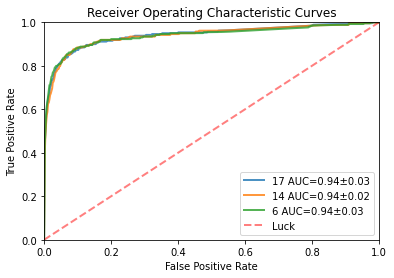


variation 3 -> learning_rate
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 6400, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
5,sgd,logistic,True,"(4,)",0.05,adaptive,800,9,3,0.914244,0.085756,0.937839
6,sgd,logistic,True,"(2,)",0.05,constant,200,9,3,0.904139,0.095861,0.936817
0,sgd,logistic,True,"(4,)",0.05,constant,6400,9,3,0.900830,0.099170,0.936199
2,sgd,logistic,True,"(4,)",0.05,adaptive,6400,9,3,0.906287,0.093713,0.935231
3,sgd,logistic,True,"(4,)",0.05,constant,800,9,3,0.899848,0.100152,0.933977
8,sgd,logistic,True,"(2,)",0.05,adaptive,200,9,3,0.911385,0.088615,0.930415
4,sgd,logistic,True,"(4,)",0.05,invscaling,800,9,3,0.860321,0.139679,0.916499
1,sgd,logistic,True,"(4,)",0.05,invscaling,6400,9,3,0.869087,0.130913,0.915779
7,sgd,logistic,True,"(2,)",0.05,invscaling,200,9,3,0.838242,0.161758,0.915600


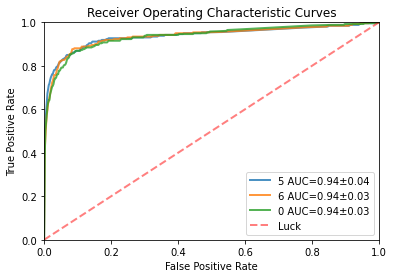


variation 4 -> activation
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 6400, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
3,sgd,relu,True,"(2,)",0.05,constant,200,9,3,0.941605,0.058395,0.939487
1,sgd,logistic,True,"(4,)",0.05,adaptive,800,9,3,0.918267,0.081733,0.939215
5,sgd,tanh,True,"(2,)",0.05,constant,200,9,3,0.921221,0.078779,0.938774
2,sgd,tanh,True,"(4,)",0.05,adaptive,800,9,3,0.931683,0.068317,0.938183
8,sgd,tanh,True,"(4,)",0.05,constant,6400,9,3,0.933023,0.066977,0.938106
7,sgd,logistic,True,"(4,)",0.05,constant,6400,9,3,0.906732,0.093268,0.934465
0,sgd,relu,True,"(4,)",0.05,adaptive,800,9,3,0.932577,0.067423,0.934413
4,sgd,logistic,True,"(2,)",0.05,constant,200,9,3,0.919881,0.080119,0.932209
6,sgd,relu,True,"(4,)",0.05,constant,6400,9,3,0.943573,0.056427,0.931280


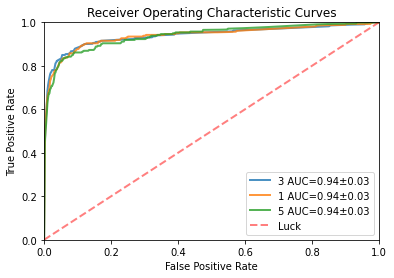


best configuration


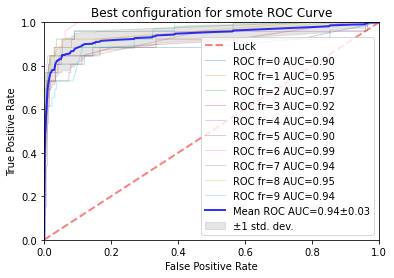

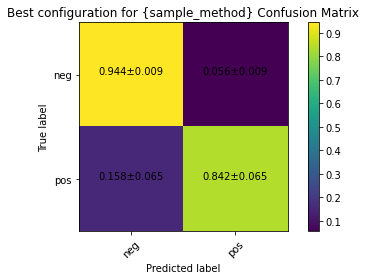

testing overfiting (increased verbose)
run 1 of 1, fold 1 of 10
run 1 of 1, fold 2 of 10
run 1 of 1, fold 3 of 10
run 1 of 1, fold 4 of 10
run 1 of 1, fold 5 of 10
run 1 of 1, fold 6 of 10
run 1 of 1, fold 7 of 10
run 1 of 1, fold 8 of 10
run 1 of 1, fold 9 of 10
run 1 of 1, fold 10 of 10


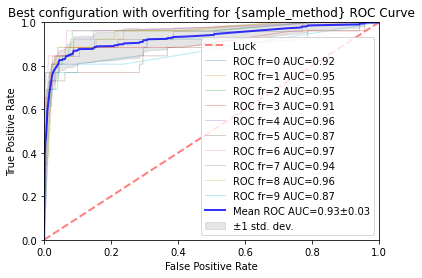

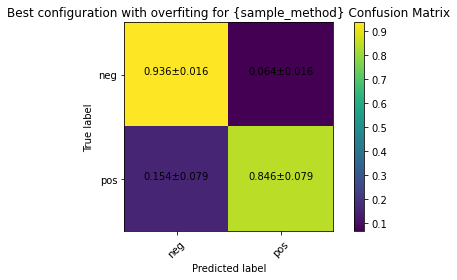




optimize model configuration for k-means with configuration range of 3
variation 0 -> learning_rate_init
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
16,sgd,logistic,True,"(32,)",0.0100,constant,3200,9,3,0.848860,0.151140,0.906375
17,sgd,logistic,True,"(32,)",0.0500,constant,3200,9,3,0.916210,0.083790,0.894069
11,sgd,logistic,True,"(16,)",0.0500,adaptive,800,9,3,0.841803,0.158197,0.890801
10,sgd,logistic,True,"(16,)",0.0100,adaptive,800,9,3,0.736244,0.263756,0.822061
9,sgd,logistic,True,"(16,)",0.0050,adaptive,800,9,3,0.723446,0.276554,0.814643
5,sgd,logistic,True,"(8,)",0.0500,invscaling,200,9,3,0.813806,0.186194,0.751846
8,sgd,logistic,True,"(16,)",0.0010,adaptive,800,9,3,0.754581,0.245419,0.751800
15,sgd,logistic,True,"(32,)",0.0050,constant,3200,9,3,0.702273,0.297727,0.663934
14,sgd,logistic,True,"(32,)",0.0010,constant,3200,9,3,0.524051,0.475949,0.652565
4,sgd,logistic,True,"(8,)",0.0100,invscaling,200,9,3,0.677991,0.322009,0.619931


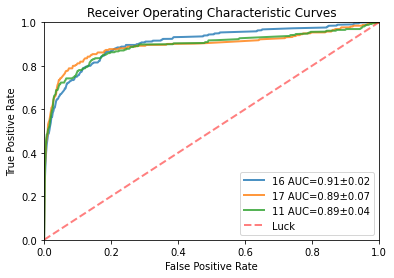


variation 1 -> hidden_layer_sizes
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
9,sgd,logistic,True,"(8,)",0.05,constant,3200,9,3,0.881422,0.118578,0.909976
6,sgd,logistic,True,"(128,)",0.01,constant,3200,9,3,0.883231,0.116769,0.903488
19,sgd,logistic,True,"(64,)",0.05,adaptive,800,9,3,0.860676,0.139324,0.901655
16,sgd,logistic,True,"(8,)",0.05,adaptive,800,9,3,0.859335,0.140665,0.900842
12,sgd,logistic,True,"(64,)",0.05,constant,3200,9,3,0.872566,0.127434,0.900745
13,sgd,logistic,True,"(128,)",0.05,constant,3200,9,3,0.857185,0.142815,0.898847
11,sgd,logistic,True,"(32,)",0.05,constant,3200,9,3,0.908438,0.091562,0.897782
5,sgd,logistic,True,"(64,)",0.01,constant,3200,9,3,0.840777,0.159223,0.894965
20,sgd,logistic,True,"(128,)",0.05,adaptive,800,9,3,0.890288,0.109712,0.894882
17,sgd,logistic,True,"(16,)",0.05,adaptive,800,9,3,0.885182,0.114818,0.894331


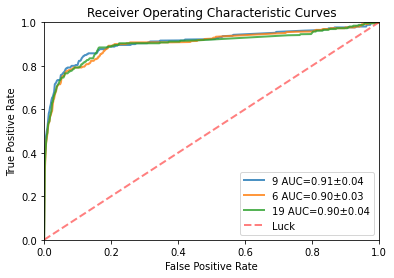


variation 2 -> max_iter
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
10,sgd,logistic,True,"(128,)",0.01,constant,3200,9,3,0.824056,0.175944,0.905633
9,sgd,logistic,True,"(128,)",0.01,constant,1600,9,3,0.915226,0.084774,0.903452
13,sgd,logistic,True,"(64,)",0.05,adaptive,400,9,3,0.862375,0.137625,0.901980
16,sgd,logistic,True,"(64,)",0.05,adaptive,3200,9,3,0.909137,0.090863,0.900750
6,sgd,logistic,True,"(128,)",0.01,constant,200,9,3,0.906289,0.093711,0.900019
5,sgd,logistic,True,"(8,)",0.05,constant,6400,9,3,0.870339,0.129661,0.900013
15,sgd,logistic,True,"(64,)",0.05,adaptive,1600,9,3,0.865423,0.134577,0.899320
4,sgd,logistic,True,"(8,)",0.05,constant,3200,9,3,0.890011,0.109989,0.899099
14,sgd,logistic,True,"(64,)",0.05,adaptive,800,9,3,0.916394,0.083606,0.898989
17,sgd,logistic,True,"(64,)",0.05,adaptive,6400,9,3,0.877138,0.122862,0.898516


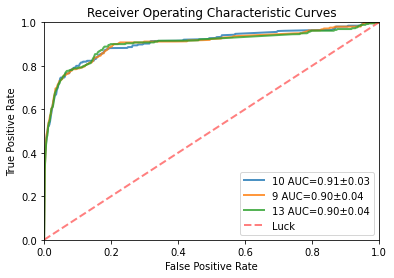


variation 3 -> learning_rate
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'max_iter': 1600, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 400, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
3,sgd,logistic,True,"(128,)",0.01,constant,1600,9,3,0.885628,0.114372,0.903829
2,sgd,logistic,True,"(128,)",0.01,adaptive,3200,9,3,0.903876,0.096124,0.899831
6,sgd,logistic,True,"(64,)",0.05,constant,400,9,3,0.901008,0.098992,0.899720
8,sgd,logistic,True,"(64,)",0.05,adaptive,400,9,3,0.887782,0.112218,0.899192
0,sgd,logistic,True,"(128,)",0.01,constant,3200,9,3,0.885633,0.114367,0.897161
5,sgd,logistic,True,"(128,)",0.01,adaptive,1600,9,3,0.871228,0.128772,0.891103
7,sgd,logistic,True,"(64,)",0.05,invscaling,400,9,3,0.616833,0.383167,0.807845
4,sgd,logistic,True,"(128,)",0.01,invscaling,1600,9,3,0.766398,0.233602,0.746367
1,sgd,logistic,True,"(128,)",0.01,invscaling,3200,9,3,0.634894,0.365106,0.586492


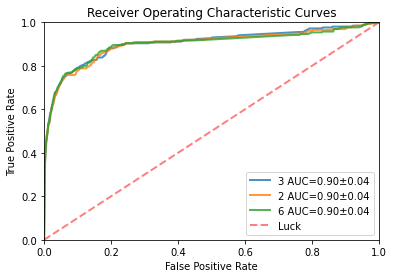


variation 4 -> activation
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'max_iter': 1600, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 400, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
5,sgd,tanh,True,"(128,)",0.01,adaptive,3200,9,3,0.781538,0.218462,0.902163
7,sgd,logistic,True,"(64,)",0.05,constant,400,9,3,0.879989,0.120011,0.902112
4,sgd,logistic,True,"(128,)",0.01,adaptive,3200,9,3,0.903516,0.096484,0.900809
8,sgd,tanh,True,"(64,)",0.05,constant,400,9,3,0.857011,0.142989,0.895260
2,sgd,tanh,True,"(128,)",0.01,constant,1600,9,3,0.824922,0.175078,0.892736
3,sgd,relu,True,"(128,)",0.01,adaptive,3200,9,3,0.831623,0.168377,0.892239
6,sgd,relu,True,"(64,)",0.05,constant,400,9,3,0.835285,0.164715,0.888621
0,sgd,relu,True,"(128,)",0.01,constant,1600,9,3,0.761898,0.238102,0.882644
1,sgd,logistic,True,"(128,)",0.01,constant,1600,9,3,0.899232,0.100768,0.865845


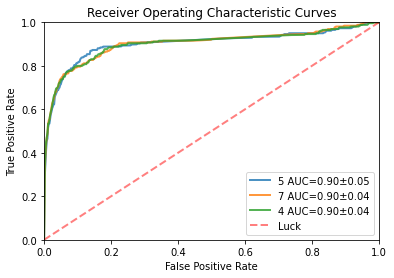


best configuration


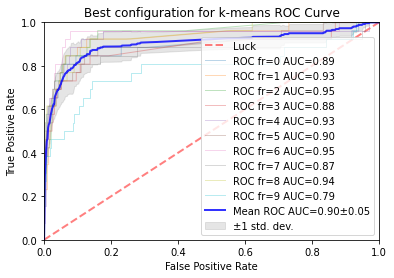

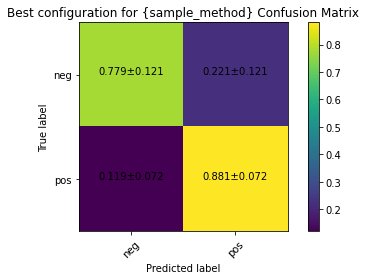

testing overfiting (increased verbose)
run 1 of 1, fold 1 of 10
run 1 of 1, fold 2 of 10
run 1 of 1, fold 3 of 10
run 1 of 1, fold 4 of 10
run 1 of 1, fold 5 of 10
run 1 of 1, fold 6 of 10
run 1 of 1, fold 7 of 10
run 1 of 1, fold 8 of 10
run 1 of 1, fold 9 of 10
run 1 of 1, fold 10 of 10


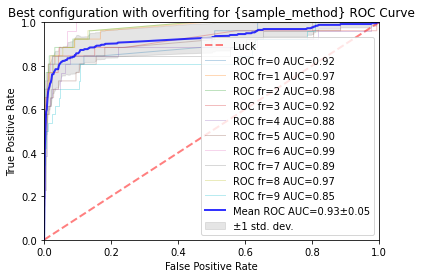

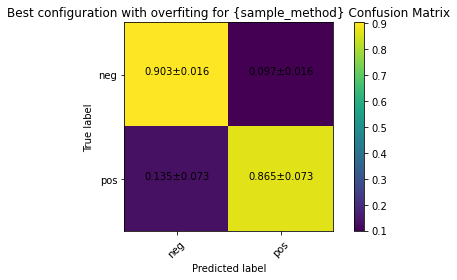




optimize model configuration for r-under with configuration range of 3
variation 0 -> learning_rate_init
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
17,sgd,logistic,True,"(32,)",0.0500,constant,3200,9,3,0.868828,0.131172,0.897451
10,sgd,logistic,True,"(16,)",0.0100,adaptive,800,9,3,0.793698,0.206302,0.893577
11,sgd,logistic,True,"(16,)",0.0500,adaptive,800,9,3,0.828214,0.171786,0.891116
5,sgd,logistic,True,"(8,)",0.0500,invscaling,200,9,3,0.661447,0.338553,0.849444
16,sgd,logistic,True,"(32,)",0.0100,constant,3200,9,3,0.756872,0.243128,0.809500
15,sgd,logistic,True,"(32,)",0.0050,constant,3200,9,3,0.462734,0.537266,0.661996
9,sgd,logistic,True,"(16,)",0.0050,adaptive,800,9,3,0.413650,0.586350,0.597441
6,sgd,logistic,True,"(16,)",0.0001,adaptive,800,9,3,0.533186,0.466814,0.581000
12,sgd,logistic,True,"(32,)",0.0001,constant,3200,9,3,0.227994,0.772006,0.580868
8,sgd,logistic,True,"(16,)",0.0010,adaptive,800,9,3,0.231654,0.768346,0.559367


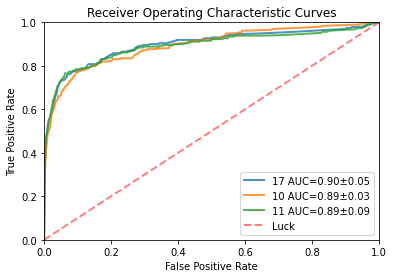


variation 1 -> hidden_layer_sizes
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
5,sgd,logistic,True,"(64,)",0.05,constant,3200,9,3,0.888952,0.111048,0.913033
6,sgd,logistic,True,"(128,)",0.05,constant,3200,9,3,0.888302,0.111698,0.912770
19,sgd,logistic,True,"(64,)",0.05,adaptive,800,9,3,0.885625,0.114375,0.911743
20,sgd,logistic,True,"(128,)",0.05,adaptive,800,9,3,0.856216,0.143784,0.911257
16,sgd,logistic,True,"(8,)",0.05,adaptive,800,9,3,0.840751,0.159249,0.909247
3,sgd,logistic,True,"(16,)",0.05,constant,3200,9,3,0.885895,0.114105,0.908221
17,sgd,logistic,True,"(16,)",0.05,adaptive,800,9,3,0.862993,0.137007,0.907465
4,sgd,logistic,True,"(32,)",0.05,constant,3200,9,3,0.864434,0.135566,0.907098
13,sgd,logistic,True,"(128,)",0.01,adaptive,800,9,3,0.873460,0.126540,0.904969
18,sgd,logistic,True,"(32,)",0.05,adaptive,800,9,3,0.882677,0.117323,0.904158


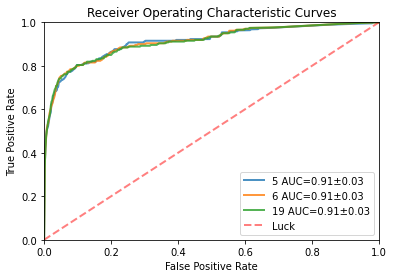


variation 2 -> max_iter
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
2,sgd,logistic,True,"(64,)",0.05,constant,800,9,3,0.828494,0.171506,0.913979
6,sgd,logistic,True,"(128,)",0.05,constant,200,9,3,0.857987,0.142013,0.912639
12,sgd,logistic,True,"(64,)",0.05,adaptive,200,9,3,0.856831,0.143169,0.912122
16,sgd,logistic,True,"(64,)",0.05,adaptive,3200,9,3,0.878657,0.121343,0.911912
10,sgd,logistic,True,"(128,)",0.05,constant,3200,9,3,0.850056,0.149944,0.911708
14,sgd,logistic,True,"(64,)",0.05,adaptive,800,9,3,0.858980,0.141020,0.911601
8,sgd,logistic,True,"(128,)",0.05,constant,800,9,3,0.903059,0.096941,0.911215
15,sgd,logistic,True,"(64,)",0.05,adaptive,1600,9,3,0.877311,0.122689,0.910631
11,sgd,logistic,True,"(128,)",0.05,constant,6400,9,3,0.879632,0.120368,0.910341
5,sgd,logistic,True,"(64,)",0.05,constant,6400,9,3,0.867479,0.132521,0.910203


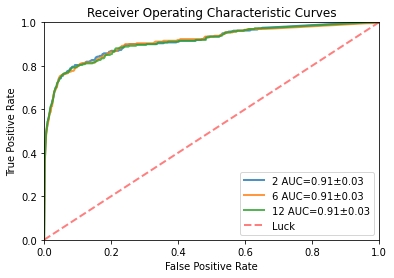


variation 3 -> learning_rate
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
5,sgd,logistic,True,"(128,)",0.05,adaptive,200,9,3,0.868723,0.131277,0.914337
8,sgd,logistic,True,"(64,)",0.05,adaptive,200,9,3,0.865796,0.134204,0.913837
6,sgd,logistic,True,"(64,)",0.05,constant,200,9,3,0.862904,0.137096,0.911565
3,sgd,logistic,True,"(128,)",0.05,constant,200,9,3,0.864080,0.135920,0.911394
2,sgd,logistic,True,"(64,)",0.05,adaptive,800,9,3,0.876953,0.123047,0.911177
0,sgd,logistic,True,"(64,)",0.05,constant,800,9,3,0.858532,0.141468,0.905032
4,sgd,logistic,True,"(128,)",0.05,invscaling,200,9,3,0.544631,0.455369,0.883575
7,sgd,logistic,True,"(64,)",0.05,invscaling,200,9,3,0.455229,0.544771,0.823361
1,sgd,logistic,True,"(64,)",0.05,invscaling,800,9,3,0.624517,0.375483,0.740493


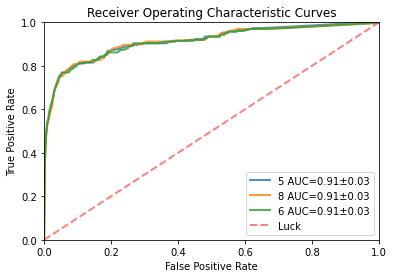


variation 4 -> activation
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}


,solver,activation,early_stopping,hidden_layer_sizes,learning_rate_init,learning_rate,max_iter,train_folds,max_fail,mean score,mean mse,mean roc auc
0,sgd,relu,True,"(128,)",0.05,adaptive,200,9,3,0.858524,0.141476,0.918817
3,sgd,relu,True,"(64,)",0.05,adaptive,200,9,3,0.831439,0.168561,0.916240
2,sgd,tanh,True,"(128,)",0.05,adaptive,200,9,3,0.820355,0.179645,0.914521
1,sgd,logistic,True,"(128,)",0.05,adaptive,200,9,3,0.868811,0.131189,0.912290
4,sgd,logistic,True,"(64,)",0.05,adaptive,200,9,3,0.884015,0.115985,0.911646
6,sgd,relu,True,"(64,)",0.05,constant,200,9,3,0.788681,0.211319,0.910614
7,sgd,logistic,True,"(64,)",0.05,constant,200,9,3,0.846292,0.153708,0.910527
5,sgd,tanh,True,"(64,)",0.05,adaptive,200,9,3,0.850208,0.149792,0.909735
8,sgd,tanh,True,"(64,)",0.05,constant,200,9,3,0.794055,0.205945,0.907841


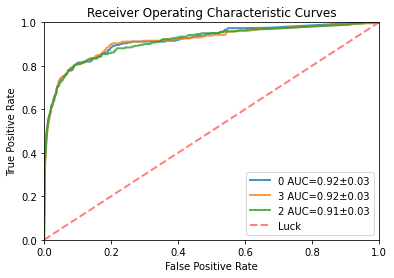


best configuration


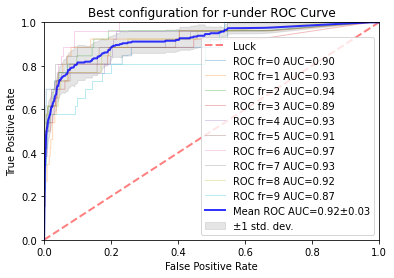

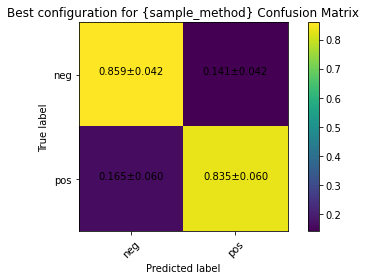

testing overfiting (increased verbose)
run 1 of 1, fold 1 of 10
run 1 of 1, fold 2 of 10
run 1 of 1, fold 3 of 10
run 1 of 1, fold 4 of 10
run 1 of 1, fold 5 of 10
run 1 of 1, fold 6 of 10
run 1 of 1, fold 7 of 10
run 1 of 1, fold 8 of 10
run 1 of 1, fold 9 of 10
run 1 of 1, fold 10 of 10


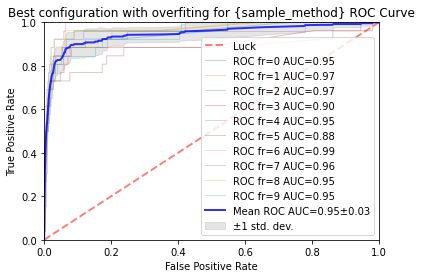

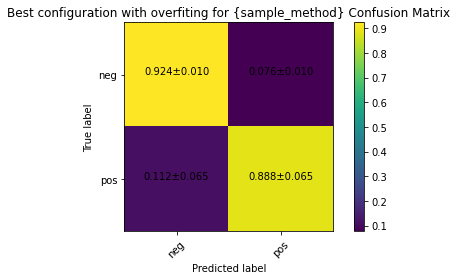

In [7]:
configuration_range = 3

for sample_method, sample_folds in samples_folds.items():
    print(f'optimize model configuration for {sample_method} with configuration range of {configuration_range}')
    configurations = base_configurations
    results = None
    for i, (variation_name, variation_values) in enumerate(variations):
        print(f'variation {i} -> {variation_name}')
        configurations_results = validate_model_configurations_variations(model_class, configurations,
                                                                          variation_name, variation_values,
                                                                          sample_folds, base_folds,
                                                                          verbose=1)

        db_frame = pd.DataFrame([configuration for configuration, result in configurations_results])
        db_frame['mean score'] = [np.mean(result['score']) for _, result in configurations_results]
        db_frame['mean mse'] = [np.mean(result['mse']) for _, result in configurations_results]
        db_frame['mean roc auc'] = [np.mean(result['roc']['auc']) for _, result in configurations_results]
        db_frame['data'] = [(c, r) for c, r in configurations_results]
        db_frame.drop_duplicates([column for column in db_frame if column != 'data'], inplace=True)

        db_frame.sort_values(by=['mean roc auc', 'mean score'], ascending=[False, False], inplace=True)
        filtered_data_frame = db_frame[[column for column in db_frame if column != 'data']]
        if NOTEBOOK:
            display(filtered_data_frame)
        else:
            print(filtered_data_frame.to_string())

        configurations = [c for c, _ in db_frame['data'][:min(configuration_range, len(db_frame['data']))]]
        results = [r for _, r in db_frame['data'][:min(configuration_range, len(db_frame['data']))]]
        plot_multi_configuration_roc_curves((r['roc'] for r in results), db_frame.index)
        print()

    print('best configuration')
    best_configuration = configurations[0]
    best_configuration_results = results[0]
    plot_single_configuration_roc_curves(best_configuration_results['roc'],
                                         title=f'Best configuration for {sample_method} ROC Curve')
    plot_single_configuration_confusion_matrix(best_configuration_results['matrix'], ['neg', 'pos'],
                                               title='Best configuration for {sample_method} Confusion Matrix')

    print('testing overfiting (increased verbose)')
    overfiting_configuration = best_configuration.copy()
    overfiting_configuration['max_fail'] = 1000
    overfiting_configuration['max_iter'] = 30000
    overfiting_configuration_results = validate_model(model_class(**overfiting_configuration), sample_folds,
                                                      base_folds, verbose=3)
    plot_single_configuration_roc_curves(overfiting_configuration_results['roc'],
                                         title='Best configuration with overfiting for {sample_method} ROC Curve')
    plot_single_configuration_confusion_matrix(overfiting_configuration_results['matrix'], ['neg', 'pos'],
                                               title='Best configuration with overfiting for {sample_method} Confusion Matrix')
    print()
    print()
    print()